<a href="https://colab.research.google.com/github/SEBASTIANVALDIVIESO/PRODUCTO_DATOS/blob/main/04_MODELADO_ML_(archivo_de_predicciones)_Version_final_15_feb_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. MODELADO PREDICCION DE LA DEMANDA FUTURA DE INTERNET EN COLOMBIA**

# Importacion de Base de datos, Librerias..

In [ ]:
# Elaborar un cuadro donde se diga porque se selecciono ese modelo?



# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/Notebooks_Clase_2/content/producto_de_datos

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Notebooks_Clase_2/content/producto_de_datos


In [ ]:
# Ruta completa del archivo CSV
file_path = 'DATOS_LIMPIOS.csv'

df = pd.read_csv(file_path)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 1️⃣ Cargar y preparar los datos
datos_completos_df = pd.read_csv('DATOS_LIMPIOS.csv')

# Convertir la columna "FECHA" a datetime y extraer el año y mes
datos_completos_df["FECHA"] = pd.to_datetime(datos_completos_df["FECHA"], errors='coerce')
datos_completos_df["AÑO"] = datos_completos_df["FECHA"].dt.year
datos_completos_df["MES"] = datos_completos_df["FECHA"].dt.month

# Guardar copia del código de municipio antes de codificarlo
datos_completos_df["COD_MUNICIPIO_ORIGINAL"] = datos_completos_df["COD_MUNICIPIO"].astype(str)

# Codificar solo "PROVEEDOR" por frecuencia
def encode_frequency(column):
    freq = datos_completos_df[column].value_counts(normalize=True)
    return datos_completos_df[column].map(freq)

datos_completos_df["PROVEEDOR"] = encode_frequency("PROVEEDOR")

# Aplicar One-Hot Encoding a "SEGMENTO" y "TECNOLOGIA"
datos_completos_encoded = pd.get_dummies(datos_completos_df, columns=["SEGMENTO", "TECNOLOGIA"], drop_first=True)

# Separar datos en entrenamiento (<=2022) y prueba (2023)
train_df = datos_completos_encoded[datos_completos_encoded["AÑO"] <= 2022]
test_df = datos_completos_encoded[datos_completos_encoded["AÑO"] == 2023]

# Separar variables predictoras y objetivo sin usar COD_MUNICIPIO como predictor
X_train = train_df.drop(columns=["SUSCRIPTORES", "FECHA", "AÑO", "MES", "COD_MUNICIPIO"])
y_train = train_df["SUSCRIPTORES"]

X_test = test_df.drop(columns=["SUSCRIPTORES", "FECHA", "AÑO", "MES", "COD_MUNICIPIO"])
y_test = test_df["SUSCRIPTORES"]

# Entrenar el modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Hacer predicciones en entrenamiento y prueba
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calcular errores
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Mostrar métricas del modelo
print(f"MSE Entrenamiento: {mse_train:.2f}, R² Entrenamiento: {r2_train:.4f}")
print(f"MSE Prueba: {mse_test:.2f}, R² Prueba: {r2_test:.4f}")

MSE Entrenamiento: 3407.97, R² Entrenamiento: 0.9970
MSE Prueba: 6984.26, R² Prueba: 0.9715


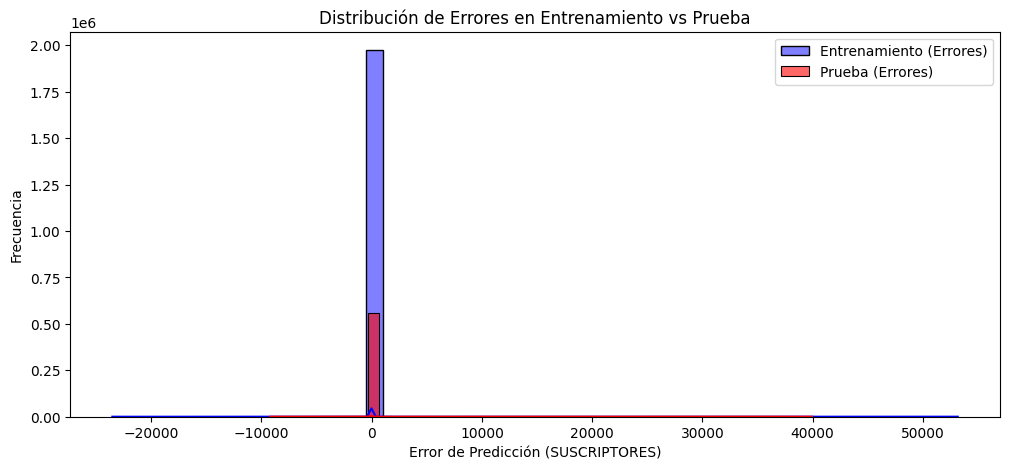

In [ ]:
# Visualizar distribución de errores
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

plt.figure(figsize=(12, 5))
sns.histplot(residuals_train, bins=50, color='blue', label="Entrenamiento (Errores)", kde=True)
sns.histplot(residuals_test, bins=50, color='red', label="Prueba (Errores)", kde=True, alpha=0.6)
plt.xlabel("Error de Predicción (SUSCRIPTORES)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Errores en Entrenamiento vs Prueba")
plt.legend()
plt.show()

In [ ]:
# Restaurar los valores originales de COD_MUNICIPIO antes de exportar
test_df["COD_MUNICIPIO"] = test_df["COD_MUNICIPIO_ORIGINAL"]

<ipython-input-6-e92ba71656ff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["COD_MUNICIPIO"] = test_df["COD_MUNICIPIO_ORIGINAL"]


In [ ]:
# Generar archivo CSV para Tableau con más variables disponibles
test_df["SUSCRIPTORES_PREDICHOS"] = y_test_pred
test_df[["COD_MUNICIPIO", "AÑO", "MES", "FECHA", "PROVEEDOR", "VELOCIDAD_SUBIDA", "ANCHO_BANDA", "SUSCRIPTORES", "SUSCRIPTORES_PREDICHOS"]].to_csv("predicciones_tableau.csv", index=False)
print("Archivo 'predicciones_tableau.csv' generado correctamente con todos los meses disponibles y más variables para análisis en Tableau.")


<ipython-input-9-bd6daba122d2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["SUSCRIPTORES_PREDICHOS"] = y_test_pred


Archivo 'predicciones_tableau.csv' generado correctamente con todos los meses disponibles y más variables para análisis en Tableau.


In [ ]:
from google.colab import files
files.download("predicciones_tableau.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Visualizar las primeras filas del dataset
print("\nPrimeras filas del dataset:")
print(df.head())


Primeras filas del dataset:
        FECHA                                PROVEEDOR  COD_MUNICIPIO  \
0  2023-06-30                    DIRECTV COLOMBIA LTDA           8520   
1  2021-06-30                              COCOM S.A.S          63272   
2  2021-03-31      COMUNICACION CELULAR S A COMCEL S A           8001   
3  2021-09-30  COLOMBIA TELECOMUNICACIONES S.A. E.S.P.          76001   
4  2023-09-30                          DIFUDATOS S A S          25224   

               SEGMENTO              TECNOLOGIA  VELOCIDAD_BAJADA  \
0  RESIDENCIAL_ESTRATO1  TECNOLOGIA_INALAMBRICA                 6   
1  RESIDENCIAL_ESTRATO2  TECNOLOGIA_INALAMBRICA                 5   
2  RESIDENCIAL_ESTRATO2         TECNOLOGIA_FIJA                10   
3  RESIDENCIAL_ESTRATO5            FIBRA_OPTICA                15   
4           CORPORATIVO  TECNOLOGIA_INALAMBRICA                30   

   VELOCIDAD_SUBIDA  SUSCRIPTORES  ANCHO_BANDA  
0                 1             3           18  
1                 5

In [ ]:
print("Columnas disponibles en el dataset:")
print(df.columns.tolist())

Columnas disponibles en el dataset:
['FECHA', 'PROVEEDOR', 'COD_MUNICIPIO', 'SEGMENTO', 'TECNOLOGIA', 'VELOCIDAD_BAJADA', 'VELOCIDAD_SUBIDA', 'SUSCRIPTORES', 'ANCHO_BANDA']


# **CODIFICACION**

In [ ]:
# Suponiendo que 'df' es tu DataFrame y 'FECHA' es una columna en formato datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])  # Asegúrate de que la columna esté en formato datetime

# Crear nuevas columnas para el año, mes y día como enteros
df['AÑO'] = df['FECHA'].dt.year.astype(int)
df['MES'] = df['FECHA'].dt.month.astype(int)
df['DIA'] = df['FECHA'].dt.day.astype(int)

# Mostrar el DataFrame resultante con las nuevas columnas
print(df)

In [ ]:
# Reordenar las columnas para colocar AÑO, MES, DIA al principio
df = df[['AÑO', 'MES', 'DIA'] + [col for col in df.columns if col not in ['AÑO', 'MES', 'DIA']]]

In [ ]:
#Elimina duplicados:

df = df.drop_duplicates()
print(df.duplicated().sum())

In [ ]:
df = df.dropna()

In [ ]:
for i in df.columns:
    print ("%20s"%i, np.sum(df[i].isna()))

**- CODIFICACION DE VARIABLES CATEGORICAS (SEGMENTO, TECNOLOGIA Y PROVEEDOR)**

In [ ]:
import pandas as pd
import numpy as np

def to_onehot(values):
    """Convierte un array de valores a una codificación One-Hot."""
    # Convertir todos los valores a string para evitar errores de comparación entre tipos
    values = values.astype(str)
    unique_values = np.unique(values)
    return np.array([[1 if value == u else 0 for u in unique_values] for value in values])

def replace_columns_with_onehot(d, cols):
    """Reemplaza varias columnas por su versión One-Hot en el DataFrame."""
    for col in cols:
        # Asegurarse de que no haya valores nulos, convirtiéndolos en una categoría separada
        d[col] = d[col].fillna('missing')  # O cualquier valor adecuado para 'NaN'

        # Convertir la columna a string para evitar problemas con tipos mixtos
        k = to_onehot(d[col].astype(str).values)

        # Usar los valores únicos de la columna para los nombres de las columnas One-Hot
        unique_values = np.unique(d[col].values)
        onehot_df = pd.DataFrame(k, columns=[f"{col}_{u}" for u in unique_values], index=d.index)

        # Unir las nuevas columnas One-Hot y eliminar la columna original
        d = d.join(onehot_df)
        del d[col]

    return d

# Reemplazar las columnas 'SEGMENTO' y 'TECNOLOGIA' por sus versiones One-Hot
df = replace_columns_with_onehot(df, ['SEGMENTO', 'TECNOLOGIA'])


In [ ]:
df = df.drop(columns=['FECHA'])

In [ ]:
label_encoder = LabelEncoder()
df['PROVEEDOR'] = label_encoder.fit_transform(df['PROVEEDOR'])
df

In [ ]:
df.dtypes

In [ ]:
df.head(30)

In [ ]:
from google.colab import files
import pandas as pd

# Supongamos que df es tu DataFrame
df.to_csv("archivo.csv", index=False)

# Descargar el archivo
files.download("archivo.csv")

# **2. ENTRENAMIENTO CON RandomForestRegressor**

In [ ]:
print(df.columns.tolist())

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# 1. Selección de variables relevantes
variables_relevantes = ['AÑO', 'MES', 'DIA', 'PROVEEDOR', 'COD_MUNICIPIO', 'VELOCIDAD_BAJADA', 'VELOCIDAD_SUBIDA', 'SUSCRIPTORES', 'ANCHO_BANDA', 'SEGMENTO_CORPORATIVO', 'SEGMENTO_RESIDENCIAL_ESTRATO1', 'SEGMENTO_RESIDENCIAL_ESTRATO2', 'SEGMENTO_RESIDENCIAL_ESTRATO3', 'SEGMENTO_RESIDENCIAL_ESTRATO4', 'SEGMENTO_RESIDENCIAL_ESTRATO5', 'SEGMENTO_RESIDENCIAL_ESTRATO6', 'SEGMENTO_SIN_ESTRATIFICAR', 'SEGMENTO_USO_PROPIO_INTERNO_DEL_OPERADOR', 'TECNOLOGIA_FIBRA_OPTICA', 'TECNOLOGIA_HIBRIDA', 'TECNOLOGIA_OTRAS_TECNOLOGIAS', 'TECNOLOGIA_TECNOLOGIA_FIJA', 'TECNOLOGIA_TECNOLOGIA_INALAMBRICA']

df = df[variables_relevantes]

# 2. Muestreo de los datos para pruebas rápidas - 50%
df_sample = df.sample(frac=0.5, random_state=42)

# 3. Separar características (X) y la variable objetivo (y)
X = df_sample.drop(columns=['SUSCRIPTORES'])
y = df_sample['SUSCRIPTORES']

# 4. División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Definir el preprocesador para las columnas numéricas y categóricas
# Para las columnas numéricas utilizamos StandardScaler, y para las categóricas OneHotEncoder.
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Normalizar variables numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Codificar variables categóricas
    ])

# 6. Modelo Random Forest ajustado inicial
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=7,
                                        random_state=42, min_samples_split=10,
                                        min_samples_leaf=5))
])

# 7. Entrenar el modelo
pipeline.fit(X_train, y_train)

# 8. Predicciones y evaluación
def evaluar_modelo(pipeline, X_train, X_test, y_train, y_test):
    # Predicciones
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Métricas
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Medir precisión del modelo
    print(f'Métricas en el conjunto de entrenamiento:')
    print(f'   MSE: {mse_train:.2f}, R^2(Coeficiente de Determinación): {r2_train:.4f}')
    print(f'Métricas en el conjunto de prueba:')
    print(f'   MSE: {mse_test:.2f}, R^2(Coeficiente de Determinación): {r2_test:.4f}')

# Evaluar el modelo
evaluar_modelo(pipeline, X_train, X_test, y_train, y_test)


In [ ]:
# 9. Exportar las predicciones para Tableau
def exportar_predicciones(pipeline, X_test, y_test, output_path="predicciones_random_forest.csv"):
    # Generar predicciones
    y_pred = pipeline.predict(X_test)

    # Crear un DataFrame con las características originales, valores reales y predicciones
    resultados = X_test.copy()
    resultados['Real'] = y_test.values  # Valores reales
    resultados['Predicción'] = y_pred  # Predicciones del modelo

    # Guardar en un archivo CSV
    resultados.to_csv(output_path, index=False)
    print(f"Archivo exportado a: {output_path}")

# Exportar los resultados
exportar_predicciones(pipeline, X_test, y_test)

In [ ]:
from google.colab import files
files.download("predicciones_random_forest.csv")

In [ ]:
from sklearn.model_selection import cross_val_score

# Usando el Random Forest como ejemplo:
scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')  # Cambiar por el modelo que uses
print(f'MSE promedio en 5 particiones: {-scores.mean():.2f}')


In [ ]:
from sklearn.model_selection import cross_val_score

# Realizar la validación cruzada con el modelo y los datos de entrenamiento
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Promedio de las puntuaciones de los 5 pliegues (folds)
print(f'MSE promedio en validación cruzada: {-cv_scores.mean():.2f}')



# **3. ENTRENAMIENTO CON XGBoost**

In [ ]:
# 2. Selección de las características (X) y la variable objetivo (y)
X = df[['AÑO', 'MES', 'DIA', 'PROVEEDOR', 'COD_MUNICIPIO', 'VELOCIDAD_BAJADA', 'VELOCIDAD_SUBIDA', 'SUSCRIPTORES', 'ANCHO_BANDA', 'SEGMENTO_CORPORATIVO', 'SEGMENTO_RESIDENCIAL_ESTRATO1', 'SEGMENTO_RESIDENCIAL_ESTRATO2', 'SEGMENTO_RESIDENCIAL_ESTRATO3', 'SEGMENTO_RESIDENCIAL_ESTRATO4', 'SEGMENTO_RESIDENCIAL_ESTRATO5', 'SEGMENTO_RESIDENCIAL_ESTRATO6', 'SEGMENTO_SIN_ESTRATIFICAR', 'SEGMENTO_USO_PROPIO_INTERNO_DEL_OPERADOR', 'TECNOLOGIA_FIBRA_OPTICA', 'TECNOLOGIA_HIBRIDA', 'TECNOLOGIA_OTRAS_TECNOLOGIAS', 'TECNOLOGIA_TECNOLOGIA_FIJA', 'TECNOLOGIA_TECNOLOGIA_INALAMBRICA']]
y = df['SUSCRIPTORES']  # Variable objetivo: número de accesos

# 3. Normalizar las características numéricas
scaler = StandardScaler()
X[['VELOCIDAD_BAJADA', 'VELOCIDAD_SUBIDA']] = scaler.fit_transform(X[['VELOCIDAD_BAJADA', 'VELOCIDAD_SUBIDA']])

# 4. División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# 5. Crear y entrenar el modelo XGBoost

#n_estimators=200, learning_rate=0.1, max_depth=5
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# 6. Predicciones en el conjunto de entrenamiento
y_pred_train = xgb_model.predict(X_train)

# 7. Calcular el MSE y R^2 en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

# 8. Predicciones en el conjunto de test
y_pred = xgb_model.predict(X_test)

# 9. Calcular el MSE y R^2 en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

# 10. Mostrar resultados
print(f'METRICAS CONJUNTO DE ENTRENAMIENTO(TRAIN):')
print(f'   MSE: {mse_train:.2f}, R^2: {r2_train:.4f}')
print(f'METRICAS CONJUNTO DE PRUEBA(TEST):')
print(f'   MSE: {mse_test:.2f}, R^2: {r2_test:.4f}')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()


In [ ]:
pip install --upgrade scikit-learn


In [ ]:
pip install --upgrade xgboost


In [ ]:
from xgboost import XGBRegressor

class CompatibleXGBRegressor(XGBRegressor):
    def __sklearn_tags__(self):
        return super()._get_tags()

xgb_model = CompatibleXGBRegressor()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define manual parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
}

best_model = None
best_score = float("inf")
for n in param_grid['n_estimators']:
    for lr in param_grid['learning_rate']:
        for depth in param_grid['max_depth']:
            model = XGBRegressor(n_estimators=n, learning_rate=lr, max_depth=depth, random_state=42)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            mse = mean_squared_error(y_test, predictions)
            if mse < best_score:
                best_score = mse
                best_model = model

print(f"Best parameters: n_estimators={best_model.get_params()['n_estimators']}, "
      f"learning_rate={best_model.get_params()['learning_rate']}, "
      f"max_depth={best_model.get_params()['max_depth']}")
print(f"Best MSE: {best_score}")



# **4. PENDIENTE POR ENTRENAMIENTO CON LightGBM**

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1. Selección de características y variable objetivo
X = df[['AÑO', 'MES', 'DIA', 'PROVEEDOR', 'COD_MUNICIPIO', 'VELOCIDAD_BAJADA', 'VELOCIDAD_SUBIDA', 'SUSCRIPTORES', 'ANCHO_BANDA',
        'SEGMENTO_CORPORATIVO', 'SEGMENTO_RESIDENCIAL_ESTRATO1', 'SEGMENTO_RESIDENCIAL_ESTRATO2', 'SEGMENTO_RESIDENCIAL_ESTRATO3',
        'SEGMENTO_RESIDENCIAL_ESTRATO4', 'SEGMENTO_RESIDENCIAL_ESTRATO5', 'SEGMENTO_RESIDENCIAL_ESTRATO6', 'SEGMENTO_SIN_ESTRATIFICAR',
        'SEGMENTO_USO_PROPIO_INTERNO_DEL_OPERADOR', 'TECNOLOGIA_FIBRA_OPTICA', 'TECNOLOGIA_HIBRIDA', 'TECNOLOGIA_OTRAS_TECNOLOGIAS',
        'TECNOLOGIA_TECNOLOGIA_FIJA', 'TECNOLOGIA_TECNOLOGIA_INALAMBRICA']]

# Variable objetivo
y = df['SUSCRIPTORES']

# 2. División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Crear el modelo LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, max_depth=7, random_state=42)

# 4. Entrenar el modelo
lgb_model.fit(X_train, y_train)

# 5. Predicciones y evaluación
y_pred_train = lgb_model.predict(X_train)
y_pred_test = lgb_model.predict(X_test)

# 6. Calcular las métricas
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# 7. Mostrar resultados
print(f'METRICAS CONJUNTO DE ENTRENAMIENTO (TRAIN):')
print(f'   MSE: {mse_train:.2f}, R^2: {r2_train:.4f}')
print(f'METRICAS CONJUNTO DE PRUEBA (TEST):')
print(f'   MSE: {mse_test:.2f}, R^2: {r2_test:.4f}')


# **5. MODELO ARIMA**

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

# Asegúrate de que las columnas 'DIA', 'MES' y 'AÑO' existan
if 'DIA' in df.columns and 'MES' in df.columns and 'AÑO' in df.columns:
    df['FECHA'] = pd.to_datetime(df[['AÑO', 'MES', 'DIA']])
else:
    print("Las columnas 'DIA', 'MES', y 'AÑO' no están presentes en el DataFrame.")
    # Aquí podrías tomar medidas adicionales, como renombrar columnas o asignarlas manualmente.

df.set_index('FECHA', inplace=True)

# Continuar con el resto del flujo
y = df['SUSCRIPTORES']

# División en conjunto de entrenamiento y prueba
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

# Ajustar el modelo ARIMA
arima_model = ARIMA(train, order=(5, 1, 0))  # Puedes ajustar los parámetros
arima_model_fit = arima_model.fit()

# Predicciones
y_pred_train = arima_model_fit.predict(start=0, end=len(train)-1, typ='levels')
y_pred_test = arima_model_fit.forecast(steps=len(test))

# Evaluación
mse_train = mean_squared_error(train, y_pred_train)
r2_train = r2_score(train, y_pred_train)
mse_test = mean_squared_error(test, y_pred_test)
r2_test = r2_score(test, y_pred_test)

# Mostrar resultados
print(f'METRICAS CONJUNTO DE ENTRENAMIENTO (TRAIN):')
print(f'   MSE: {mse_train:.2f}, R^2: {r2_train:.4f}')
print(f'METRICAS CONJUNTO DE PRUEBA (TEST):')
print(f'   MSE: {mse_test:.2f}, R^2: {r2_test:.4f}')


# **5. PENDIENTE POR BUSQUEDA DE PARAMETROS CON GRIDSEARCH**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# 1. Selección de variables relevantes
variables_relevantes = ['AÑO', 'MES', 'DIA', 'PROVEEDOR', 'COD_MUNICIPIO', 'VELOCIDAD_BAJADA', 'VELOCIDAD_SUBIDA',
                        'SUSCRIPTORES', 'ANCHO_BANDA', 'SEGMENTO_CORPORATIVO', 'SEGMENTO_RESIDENCIAL_ESTRATO1',
                        'SEGMENTO_RESIDENCIAL_ESTRATO2', 'SEGMENTO_RESIDENCIAL_ESTRATO3', 'SEGMENTO_RESIDENCIAL_ESTRATO4',
                        'SEGMENTO_RESIDENCIAL_ESTRATO5', 'SEGMENTO_RESIDENCIAL_ESTRATO6', 'SEGMENTO_SIN_ESTRATIFICAR',
                        'SEGMENTO_USO_PROPIO_INTERNO_DEL_OPERADOR', 'TECNOLOGIA_FIBRA_OPTICA', 'TECNOLOGIA_HIBRIDA',
                        'TECNOLOGIA_OTRAS_TECNOLOGIAS', 'TECNOLOGIA_TECNOLOGIA_FIJA', 'TECNOLOGIA_TECNOLOGIA_INALAMBRICA']

df = df[variables_relevantes]

# 2. Muestreo de los datos para pruebas rápidas - 30%
df_sample = df.sample(frac=0.1, random_state=42)

# 3. Separar características (X) y la variable objetivo (y)
X = df_sample.drop(columns=['SUSCRIPTORES'])
y = df_sample['SUSCRIPTORES']

# 4. División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Definir el preprocesador para las columnas numéricas y categóricas
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Normalizar variables numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Codificar variables categóricas
    ])

# 6. Definir el pipeline con el RandomForestRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# 7. Definir el GridSearchCV con los parámetros a explorar
param_grid = {
    'regressor__n_estimators': [200, 300],
    'regressor__max_depth': [5, 7],
    'regressor__min_samples_split': [5, 10],
    'regressor__min_samples_leaf': [2, 4],

}

# 8. Crear el objeto GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=1, n_jobs=-1)

# 9. Entrenar el modelo con la búsqueda de los mejores parámetros
grid_search.fit(X_train, y_train)

# 10. Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", grid_search.best_params_)

# 11. Usar el mejor modelo encontrado para hacer predicciones
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# 12. Evaluar el modelo
def evaluar_modelo(modelo, X_train, X_test, y_train, y_test):
    # Métricas
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Mostrar resultados
    print(f'Métricas en el conjunto de entrenamiento:')
    print(f'   MSE: {mse_train:.2f}, R^2(Coeficiente de Determinación): {r2_train:.4f}')
    print(f'Métricas en el conjunto de prueba:')
    print(f'   MSE: {mse_test:.2f}, R^2(Coeficiente de Determinación): {r2_test:.4f}')

# Evaluar el modelo
evaluar_modelo(best_model, X_train, X_test, y_train, y_test)
